# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de polítics.


**Què s’ha de fer?**

Volem classificar tweets corresponents a diferents politics segons a quin partit polític pertanyen. 
A partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cada un dels tweets. 
Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quin partit polític pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. 
L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 
El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica què serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. 

# Preparar les dades

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
import pickle
from os.path import join as path, dirname

try:
    from IPython.core.display import HTML

    def pprint(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(HTML(pd.DataFrame(df).to_html()))
except:
    def pprint(df):
        print(df)

In [3]:
print('Training data')
df_tweets_train = pd.read_excel(path('data', 'train.xlsx'), index_col='Id')
pprint(df_tweets_train.head())
print(df_tweets_train.shape)

print('Test data')
df_tweets_test = pd.read_excel(path('data', 'test.xlsx'), index_col='Id')
pprint(df_tweets_test.head())
print(df_tweets_test.shape)

Training data


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
0,martarovira,erc,"Últim acte de campanya! Aquí tossudament alçats i amb un somriure per fer camí cap a la #República. Ho hem dit tan alt que l'Oriol @junqueras, avui, ens ha sentit des d'Estremera!",2017-12-19 20:12:01,785,2295
1,xavierdomenechs,comuns,"#Badalona necessita uns pressupostos que posin la ciutadania al capdavant i que segueixin recuperant els drets socials que les retallades del PP van eliminar. La transformació a Badalona no es pot aturar. Per això, tot el suport a @mariadolorsa. \n\n#DolorsAlcaldessa",2018-04-27 10:04:19,55,93
2,albert_rivera,cs,Encuentro Villacís-Valls para lanzar una estrategia electoral común en Madrid y Barcelona,2018-11-17 20:34:58,357,622
3,jaumecollboni,psc,"“La palabra es como una bala, no tiene retorno” interesante entrevista a ⁦@mcampovidal⁩",2018-10-22 18:10:01,4,6
4,albiol_xg,ppc,"📻 Esta noche, a partir de las 22:10h, me entrevistan en @linternacope. ¡Os espero!",2018-08-16 10:30:27,20,47


(1920, 6)
Test data


,text,retweet_count,favorite_count
Id,,,
0,"Avui hem représ la Comissió Mixta amb el @govern: entenem q ha estat un any difícil però necessitem q Generalitat assumeixi les seves obligacions en temes tan bàsics com habitatge, bressol, residències gent gran o llei de barris. BCN no pot esperar més:",67,103
1,"Torra anunció un ""otoño caliente"" para aumentar la tensión, el conflicto y la fractura social en Cataluña y ahora sus comandos separatistas pretenden bloquear las calles de Barcelona. Sánchez debe rectificar y defender a millones de catalanes ante los abusos del separatismo",856,1501
2,Demà cal sortir als carrers per dir que #BarcelonaNoEstaEnVenda.\n\nVolem uns lloguers i un habitatge digne. \n\nNo permetrem que venguin les ciutats als fons voltors i especuladors.,144,174
3,“Cercàvem or i vam baixar a la mina.\nI la foscor d’il·luminà de sobte\nperquè érem dos a contradir la nit” \n\nJoan Vinyoli,338,1560
4,"Molt senzill d'entendre, companya: \n1.- L'ALLIBERAMENT de dues persones innocents i honrades!\n2.- LA LLIBERTAT: que no se'ns imposi el que hem de pensar i fer!\n3.- REBUTJAR les amenaces, els tribunals, els fiscals i la policia al vostre servei per a fer oposició! \nSí, seny!",4932,7253


(480, 3)


# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### Anàlisis de dades

El primer que haurem de fer és analitzar les dades mitjançant diferents funcions.

In [4]:
def count_tweets(df):
    """
    Retorna el número de tweets en el dataframe
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : número de tweets
    """
    return df.shape[0]

def get_politicians(df):
    """
    Retorna els usuaris dels polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels usuaris
    """
    return df["username"].unique()

def count_politicians(df):
    """
    Retorna la quantitat de polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(df["username"].unique())

def get_political_party(df):
    """
    Retorna els partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels partits polítics que han tuitejat
    """
    return df["party"].unique()

def count_political_party(df):
    """
    Retorna la quantitat de partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(df["party"].unique())

def count_tweet_politician(df):
    """
    Retorna la quantitat de tweets per polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per polític
    """
    return df.groupby(["username"]).size()

def count_tweet_party(df):
    """
    Retorna la quantitat de tweets per partit polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per partit polític
    """
    return df.groupby(["party"]).size()

def top_retweet(df, n):
    """
    Retorna els n tweets que han sigut més retuitejats
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top retweets
    """
    return df.sort_values(by=["retweet_count"],ascending=False)[:n]
    
def top_favorite(df, n):
    """
    Retorna els n tweets més favorits
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top favorits
    """
    return df.sort_values(by=["favorite_count"],ascending=False)[:n]

1920
['martarovira' 'xavierdomenechs' 'albert_rivera' 'jaumecollboni'
 'albiol_xg' 'miqueliceta' 'quimtorraipla' 'adacolau' 'santirodriguez'
 'krls' 'joantarda' 'inesarrimadas'] 12
['erc' 'comuns' 'cs' 'psc' 'ppc' 'jxcat'] 6


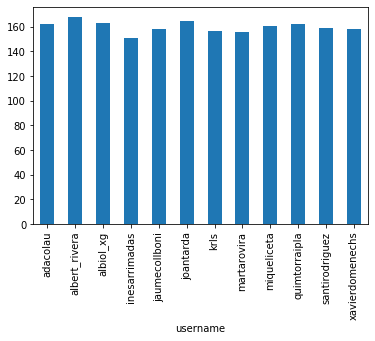

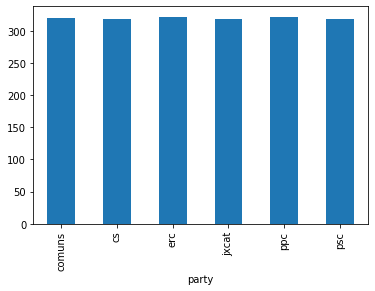

,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,"Que una republicana defienda la República es bastante previsible. De quien cuesta fiarse es de un republicano francés que de repente se vuelve monárquico. Liberté, egalité, fraternité... se quedaron en los Pirineos?",2018-10-26 22:17:38,11706,26838
781,martarovira,erc,A tots els demòcrates: no pararem fins que tornin a casa!#LlibertatPresosPolítics,2017-11-02 17:42:06,10403,19991
138,krls,jxcat,"Una causa que necessiti ser defensada amb cúters i cops de puny a periodistes (telemadrid i jordi borràs) és ben trista i no té futur, encara que tingui impunitat, diners i rei. Ho dèiem fa uns dies: l'aporellos se'ls està anant de les mans.",2018-08-29 20:21:30,10086,20357
1664,martarovira,erc,".@junqueras President d'un partit amb 86 anys d'història sense cap cas de corrupció, és a la presó per instància del partit més corrupte d'Europa: el PP. I els seus imputats, on són? Esquiant, recol•locats a l'Ibex, i es veu que no troben un tal M. Rajoy \nEl 21D, fem justícia!",2017-12-13 21:17:18,9445,15947
1515,krls,jxcat,"Perdoneu, però això és tan greu que si no hi ha conseqüències, el sistema judicial espanyol de la monarquia farà aigües definitivament. En mans de qui està un dels pilars de tot sistema democràtic?",2018-09-19 20:16:22,8806,12509


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,"Que una republicana defienda la República es bastante previsible. De quien cuesta fiarse es de un republicano francés que de repente se vuelve monárquico. Liberté, egalité, fraternité... se quedaron en los Pirineos?",2018-10-26 22:17:38,11706,26838
138,krls,jxcat,"Una causa que necessiti ser defensada amb cúters i cops de puny a periodistes (telemadrid i jordi borràs) és ben trista i no té futur, encara que tingui impunitat, diners i rei. Ho dèiem fa uns dies: l'aporellos se'ls està anant de les mans.",2018-08-29 20:21:30,10086,20357
174,krls,jxcat,Acabo d'arribar a #Escòcia convidat pel Fòrum diplomàtic @BeyondBorders__ per explicar el conflicte català. Reprenem l’activitat internacional per lluitar per la llibertat de la #RepúblicaCatalana,2018-08-24 17:55:01,6783,20018
781,martarovira,erc,A tots els demòcrates: no pararem fins que tornin a casa!#LlibertatPresosPolítics,2017-11-02 17:42:06,10403,19991
1043,krls,jxcat,"Una gran #Diada2018 per avançar cap a la república. No hi ha cap altre poble a Europa que hagi mobilitzat tants milions de persones, set anys seguits i sense incidents. Demanem votar el nostre futur i ser respectats com a nació. Gràcies a tots els qui ho esteu fent possible!",2018-09-11 18:48:43,6372,18950


In [5]:
print(count_tweets(df_tweets_train))
print(get_politicians(df_tweets_train), count_politicians(df_tweets_train))
print(get_political_party(df_tweets_train), count_political_party(df_tweets_train))

count_tweet_politician(df_tweets_train).plot.bar()
plt.show()

count_tweet_party(df_tweets_train).plot.bar()
plt.show()

pprint(top_retweet(df_tweets_train, 5))
pprint(top_favorite(df_tweets_train, 5))

### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.

No modificar la següent cel·la, s'encarrega de guardar una caché de la funció normalize per accelerar el procés.

In [6]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
        
    return memodict(f)

In [7]:
@memo
def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: inFO*RmÀ745tica? ---> informatica
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    accents = {'à':'a','á':'a','è':'e','é':'e','í':'i','ò':'o','ó':'o','ú':'u'}
    numbers = "0123456789"
    puncts= "*?!#@()·:,._-'¿"
    
    word = word.lower() #Passar a minúscula
    
    for key,valor in accents.items(): #Treure els accents
        word = word.replace(key,valor)
        word = word.replace(" ","")
   
    for symbols in puncts: #Treure simbols
        word = word.replace(symbols, "")
   
    for num in numbers: #Treure números
        word = word.replace(num, "")
    
    return word

normalize('inFO*RmÀ745tica')

'informatica'

In [8]:
def sentence_to_words(sentence):
    """
    Funció que donada una frase, generi una llista amb totes les seves paraules normalitzades.
    
    :param sentence: frase a transformar
    :return : llista de paraules (no buides) normalitzades
    
    Exemple: **Taller DELS noUS U**SOS    de la inFO#Rm765Àtica? ---> 
        ['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']
    """
    
    words = sentence.split() #Separem la frase en paraules individuals
        
    corrected_words = []
    for i in range(len(words)): #Iterem per la longitud de les paraules
        corrected_words.append(normalize(words[i])) #Normalitzem les paraules i les afegim a la llista de corrected words
    
    return corrected_words

sentence_to_words('**Taller DELS noUS U**SOS    de la inFO#Rm765Àtica?')

['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']

In [9]:
def count_words(df):
    """
    Funció que ha de construir un DataFrame amb índex les paraules normalitzades,
    i columnes n_ocur (nombre de vegades que apareix la paraula a tots els tweets)
    i n_tweets (nombre de tweets on apareix la paraula alguna vegada).
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame especificat.
    """
    texts = df["text"] #Agafem les columnes del text del dataframe, en aquest cas serien els twits
    
    word_dict = dict() #Creem un diccionari
    for text in texts: #Iterem pels twits
        sentence = sentence_to_words(text) #Agafem cada twit i el separem en paraules i a la vegada el normalitzem
        tmp = set() #Temporal per cada twit
        for word in sentence: #Iterem per les paraules 
            if word in word_dict: #Si la paraula es al diccionari
                word_dict[word]["n_ocurr"] +=1 #Sumem 1 a les ocurrencies de cada paraula
                if word not in tmp: #En cas que no estigui al temporal
                    word_dict[word]["n_tweets"] +=1 #Suemem 1 al numero de twits que surt la paraula
                    tmp.add(word)
            else:
                word_dict[word] = {"n_ocurr": 1, "n_tweets": 1} #En cas que no estigui la paraula al diccionari la afegim.
            
                
    dataFrameFinal =pd.DataFrame.from_dict(word_dict,orient="index") #Pasem el diccionari a un dataframe

    return dataFrameFinal


In [10]:
counts = count_words(df_tweets_train)
counts.head()

,n_ocurr,n_tweets
ultim,3,3
acte,13,13
de,2816,1403
campanya,12,11
aqui,31,30


### Contar paraules per partit polític

In [11]:
def count_words_parties(df):
    """
    Funció que ha de construir un DataFrame amb columnes les paraules normalitzades,
    i índex cadascún dels partits, contenint el nombre de vegades que cada paraula
    ha aparegut a tweets del partit.
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame esmentat.
    """
    parties = get_political_party(df) #Agafem tots els partits politics del dataframe
    word_dict = dict()#Creem un diccionari de paraules
    
    for index in df.index: #Iterem pels indexs del dataframe
        sentence = sentence_to_words(df.at[index,"text"]) #Creem llistes de cada frase separada en paraules
        for word in sentence:#Iterem per cada paraula d'aquestes frases
            if word in word_dict: #Si la paraula esta al diccionari
                
                word_dict[word][df.at[index,"party"]] +=1 #Sumem 1 al valor del partit que la ha escrit

            else: #En cas que no estigui
                word_dict[word] = {k:0 for k in parties} #Inicialitzem el diccionari
                word_dict[word][df.at[index,"party"]] +=1 #Sumem 1 al valor del partit que la ha escrit
            

    dataFrameFinal =pd.DataFrame.from_dict(word_dict) #Pasem el diccionari a un dataframe

    return dataFrameFinal
    

words_parties = count_words_parties(df_tweets_train)
words_parties.head()


,ultim,acte,de,campanya,aqui,tossudament,alçats,i,amb,un,...,nefastas,ocultaron,siguieron,bienal,desplazando,malestares,incertidumbres,acumulan,aceleracion,contemporaneo
erc,1,4,357,2,2,2,2,339,88,76,...,0,0,0,0,0,0,0,0,0,0
comuns,1,6,506,2,11,0,0,325,86,152,...,0,0,0,1,1,1,1,1,1,1
cs,0,0,622,0,5,0,0,11,1,141,...,1,1,1,0,0,0,0,0,0,0
psc,0,1,445,2,1,0,0,194,59,89,...,0,0,0,0,0,0,0,0,0,0
ppc,0,0,467,3,8,0,0,45,27,65,...,0,0,0,0,0,0,0,0,0,0


### Paraules més freqüents als tweets


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. 
En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. 
Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una d'exemple. 
Per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total (sense tenir en compte el partit). 
Podeu experimentar variant aquests valors.

In [12]:
skip_words = ["de","i", "a", "que", "el", "no", "per", "es", "en", "q","la","y","en", "un", "per", "una","les","els","del","d",
             "a","al","amb","d", "los", "con","se", "","por", "las","ha", "lo","ens","su","👇🏼","si","hi","o"] # depèn de vosaltres emplenar aquesta llista amb possibles paraules a excloure

In [13]:
def topNwords(df, words, N, skip=[]):
    """
    Funció que crea un pd.Series amb índex cadascún dels partits,
    i values una llista de les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascún dels partits polítics.
    
    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : pd.Series resultant.
    """

    dic = dict() #Inicialitzem diccionari
    
    for partits in words.index: #Iterem per tots els partits
        llista = [] #Creem llista
        a = words.sort_values(by = partits,axis=1,ascending = False)[:N] #Ordenem les paraules que mes apareguin segons cada partit
        contador = 0
        final = a.columns.values.copy() #Copiem els values de la columna del dataframe ordenat 
        for word in final: #iterem per les paraules
            if word in skip: #Si la paraula esta a la llista dels skip passem 
                pass
            else: #En cas contrari l'afegim a la llista
                llista.append(word)
        
        dic[partits] = llista[:N] #Afegim la llista de cada partit al diccionari
        
    series = pd.Series(dic) #Creem la pd.Series del diccionari 
  
    return series
    

    

top_words = topNwords(df_tweets_train, words_parties, 10, skip_words)

top_words

erc       [avui, esquerraerc, dels, republica, referendu...
comuns    [avui, para, barcelona, mes, bcn, ciutat, cata...
cs        [para, sanchez, mas, españa, cataluña, esta, e...
psc       [via, barcelona, para, catalunya, socialistesc...
ppc       [ppcatalunya, para, ppopular, como, hoy, badal...
jxcat     [gracies, llibertat, catalunya, the, dels, mes...
dtype: object

De cara a millores, tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria  de tweets, així com també, les que únicament apareixen en un conjunt molt petit de tweets.

### Vector de Característiques
Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes

In [14]:
def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes.
    Retorna un DataFrame on cada fila representa el vector de característiques del corresponent tweet.
    
    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el pd.Series que retorna topNWords
    :return : pd.DataFrame resultant.
    """
    
    evaluation = [] #Creem llista per les paraules a evaluar
    for partit in top_words.keys(): #Iterem pels partits del pdSeries
        for word in top_words[partit]: #Iterem per les paraules de cada partit
            if word not in evaluation: #Si la paraula no es troba a la llista la afegim
                evaluation.append(word)

    
    
    word_dict = dict() #Creem un diccionari
    
    for index in df.index: #Iterem pels twits del dataframe
        word_dict[index] ={k:0 for k in evaluation} #Creem diccionari amb el twit i les paraules que apareixen en el twit
        llista = sentence_to_words(df.at[index,"text"]) #Llista amb les paraules del twit
        for words in evaluation: #Per cada paraula dins de la llista de evaluacio
            if words in llista: #Si la paraula esta a la llista la posem a 1
                word_dict[index][words] = 1 
            else: #En cas contrari a 0 
                word_dict[index][words] = 0
                
    dataFrameFinal =pd.DataFrame.from_dict(word_dict,orient="index") #Pasem el diccionari a un dataframe

    return dataFrameFinal
    
    


In [15]:
N = 10 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.

words_parties = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_parties, N, skip_words)
features = create_features(df_tweets_train, top_words)



### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió es simplifica a:
$$ p(y|x) = c · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "comuns" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "comuns"  per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria en que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En general:
$$p(x = \text{"badalona"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'badalona' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0 !! 
Això vol dir, que si en el tweet no hi apareix una paraula no pot ser classificada com un partit polític.
No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions es fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"badalona"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

### Classificar:

Donat un vector de característiques $x=(x_1,...,x_n)$, per classificar el que farem serà calcular la probabilitat de pertànyer a cada un dels partits polítics:

$$p(\text{comuns}|x) = p(\text{comuns})\prod_{i=1}^np(x_i|\text{comuns})$$
$$\cdots$$
$$p(\text{psc}|x) = p(\text{psc})\prod_{i=1}^np(x_i|\text{psc})$$

I finalment, el tweet és del partit de probabilitat màxima. Tingues en compte que per $x_i = 0$ s'ha de considerar la probabilitat inversa, és a dir, la probabilitat de ser de la clase $C$ quan $x_i = 0$ ve donada per $1 - p(x_i|C)$

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut 
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilizades per fer entrenament (aprenentatge). Aquest error es un valor molt optimista de com funcionarà el clasificador i mai s'ha de prendre com a mesura per comparar clasificadors. 

In [16]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades.
    
    :params df: DataFrame amb els tweets i la informació associada (atribut party)
    :params feats: DataFrame de features de cada tweet.
    :return : DataFrame amb les probabilitats marginals condicionades amb la correcció de Laplace,
        on files són les feature words, i columnes són els partits.
    """
    
    
    dic = dict() #Creem diccionari
    partits = get_political_party(df) #Agafem els partits del dataframe
    M = len(partits) #Numero de partits que hi tenim
    word_prob = {} #Creem un diccionari de les paraules
    for party in partits: #Per cada partit 
        
        df_partits = df.loc[(df["party"] == party)] #Agafem els partits que coincideixen amb la iteracio
        
        partits_index = df_partits.index.values.tolist() #Agafem els indexs dels partits de la iteracio 
        num_twits = len(partits_index) # número total de tweets de cada partit
        
        
        feat_vector = np.array([0]*len(feats.columns)) #Vector de caracteristiques a 0 segons la longitud del feats
        
        for index in partits_index: #Per cada twit dels partits
            feat_vector += feats.loc[index] #L'afegim al vector de caracteristiques
            
        
        for  i in feat_vector: #Per cada valor del vector
            dic[party] = (feat_vector+1) / (num_twits+ M) #Apliquem la correcio de Laplace
            
    dataFrameFinal =pd.DataFrame.from_dict(dic,orient="index") #Pasem el diccionari a un dataframe
    
    return dataFrameFinal

In [17]:
def split_train_test(df, split):
    """
    Funció que separa les dades en training i test
    
    :param df:
    :param split: proporció de les dades que seràn per l'entrenament
    :return : retorna dos dataframes corresponents a l'entrenament i al test
    """
    assert split <= 1, 'split must be between 0 and 1'
    
    split1 = df.sample(frac = split)
    split2 = df.drop(split1.index)

    return split1,split2


In [18]:
def naive_bayes(df_train, feat_train, feat_test, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes, és a dir entrena amb les
    característiques d'entrenament i després utilitza les probabilitats estimades
    per classificar els vectors de test, segons la fórmula
    p(C_j|x) = p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)
    i agafant la màxima.
    
    Tingues en compte el problema de l'underflow:
    log(p(C_j|x)) = log(p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)) =
                  = log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                  
    I recorda, per x_i = 0 cal considerar 1 - p(x_1|C_j).
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: En cas d'estar disponible (per Kaggle no hi és), 
        DataFrame amb els tweets que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    
    probab_train = naive_bayes_learn(df_train, feat_train) #Dataframe de les probab marginals
    
    partits = probab_train.index #Partits
    top = probab_train.columns #Paraules del dataframe
    
    word_dict = dict() #Creem diccionari
    for twit in feat_test.index: #Per cada twit
        
        
        word_dict[twit] = {k:1/len(partits) for k in partits} #Creem el diccionari amb els twits i els partits
        
        paraules = feat_test.columns #Paraules del diccionari amb el vector de caracteristiques
        
        for party in partits: #Per cada partit
            prob_actual = 0 #Inicialitzem la probabilitat 
            
            for paraula in paraules:#Per cada paraula del diccionari de paraules
                
                if paraula in top and feat_test.at[twit,paraula]==1: #Si la paraula esta en el top i es un 1 al vector de caracteristiques
                    
                    prob_actual += np.log(probab_train.at[party,paraula]) #L'afegim a la probabilitat tenint en compte el underflow
                    
            word_dict[twit][party] += prob_actual #Afegim la probabilitat a la paraula del partit
            
    dataFrameFinal =pd.DataFrame.from_dict(word_dict,orient="index") #Pasem el diccionari a un dataframe
    
    maxims = dataFrameFinal.idxmax(axis=1) #Agafem els maxims del dataframe
    
    #En cas que no hi hagi df_test calcularem el encertos i errors 
    if not df_test is None:
        count = 0
        other = 0
        for i in maxims.index:
            if maxims[i] == df_test.at[i,'party']:
                count += 1
            else:
                other +=1
        print('Encerts: ' , count)
        print('Errors: ' ,other)
    
    
    series = maxims.squeeze()
    return series


In [19]:
df_train, df_test = split_train_test(df_tweets_train, 0.8)

N = 20 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor. 
words_topics = count_words_parties(df_train)
top_words = topNwords(df_train, words_topics, N, skip_words)

feat_train = create_features(df_train, top_words)
feat_test = create_features(df_test, top_words)

preds = naive_bayes(df_train, feat_train, feat_test, df_test)

preds.head()

Encerts:  215
Errors:  169


1     jxcat
6       psc
23    jxcat
29       cs
32      ppc
dtype: object

# Kaggle

https://www.kaggle.com/t/ef3079700f9e49609ff7a2e70c6fc97e

In [20]:
words_topics = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_words)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)

result = naive_bayes(df_tweets_train, feat_train, feat_test)
result.index.name = 'tweet_id'
result.name = 'party'
result.to_frame().to_csv('submission.csv')
print(result.head())

tweet_id
0    comuns
1        cs
2     jxcat
3       erc
4     jxcat
Name: party, dtype: object
